# 𝑷𝒓𝒐𝑮𝑨𝑵 for CelebA
**Author** - [Vuong NGUYEN](https://github.com/XuanMinhVuongNGUYEN)

This tutorial introduces you to the basics of the [Augmentare](https://forge.deel.ai/Fair/augmentare) library to easily use the deployment of Machine Learning techniques to augment data in **PyTorch**. This tutorial mainly explores the core features of library, the predefined losses and the models. 

This tutorial assumes that your system has installed **Pytorch** and **Augmentare** properly.

This tutorial uses the highly popular 𝑷𝒓𝒐𝒈𝒓𝒆𝒔𝒔𝒊𝒗𝒆 𝑮𝒓𝒐𝒘𝒊𝒏𝒈 𝒐𝒇 𝑮𝑨𝑵𝒔 or **ProGAN** architecture. **Augmentare** provides a generalised implementation of **ProGAN**.

**Paper** - [Progressive Growing of GANs for Improved Quality, Stability, and Variation by Tero Karras & al.](https://arxiv.org/abs/1710.10196) 

In [1]:
try:
    import augmentare
    print(f"Existing Augmentare {augmentare.__version__} installation found")

except ImportError:
    import subprocess
    import sys

    subprocess.check_call([sys.executable, "-m", "pip", "install", "augmentare"])
    import augmentare

    print(f"Installed Augmentare {augmentare.__version__}")

/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/vuong.nguyen/vuong/augmentare/dev_augmentare/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Existing Augmentare 0.0.1 installation found


## IMPORTS

In [2]:
# General Imports
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Pytorch and Torchvision Imports
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Augmentare Imports
import augmentare
from augmentare.methods.gan import *
from augmentare.plots.plot_losses import plot_losses_gan
from augmentare.plots.plot_samples import plot_image

In [3]:
#Cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## DATA LOADING AND PREPROCESSING

In [4]:
train_df = pd.read_csv('dataframe_dataset/df_female_gray.csv')
len(train_df)

894

In [5]:
image_path = "/home/vuong.nguyen/vuong/augmentare/Bias Celeba/dataset/img_align_celeba/img_align_celeba"

In [6]:
class CelebDataset(Dataset):
    def __init__(self, df, image_path, transform=None, mode='train'):
        super().__init__()
        self.sen = df['Sens']
        self.label = df['Male']
        self.path = image_path
        self.image_id = df['image_id']
        self.transform=transform
        self.mode=mode

    def __len__(self):
        return self.image_id.shape[0]

    def __getitem__(self, idx:int):
        image_name = self.image_id.iloc[idx]
        image = Image.open(os.path.join(image_path, image_name))
        labels = np.asarray(self.label.iloc[idx].T)
        sens = np.asarray(self.sen.iloc[idx].T)

        if self.transform:
            image=self.transform(image)
        return image, labels

In [7]:
image_size = 256

transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])  

dataset=CelebDataset(train_df,image_path,transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

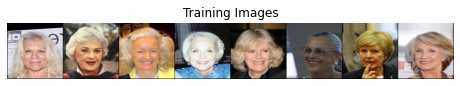

In [8]:
#Plot some training images 
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

## NETWORK ARCHITECTURE : ProGAN

### GENERATOR NETWORK
The CycleGAN Generator has 3 components:

1. A downsampling network: It is composed of 3 convolutional layers  (together with the regular padding, normalization and activation layers).
2. A chain of residual networks built using the Residual Block. You can try to vary the `ResidualBlock` parameter and see the results.
3. A upsampling network: It is composed of 3 transposed convolutional layers.

In CycleGAN Generator, we shall be using **Instance Norm** instead of **Batch Norm** and finally swap the **Zero Padding** of the Convolutional Layer with **Reflection Padding**.

### DISCRIMINATOR NETWORK
The CycleGAN Discriminator is like the standard DCGAN Discriminator. The only difference is the **Instance Normalization** used.

#### ProGAN Generator

A generator to incrementally size the output by starting with a very small image, then the blocks of layers added incrementally and increasing the input size of the discriminant model until the desired image size is obtained.

Hyperparameters:

`latent_size:` Size of latent vector (i.e size of generator input)

`in_channels:` In channels

`img_channels:` Number of channels in the training images

In [9]:
net_gen = PROGANGenerator(
    latent_size=256,
    in_channels=256,
    img_channels=3,
    alpha=1e-5,
    steps=4
)

#### ProGAN Discriminator

A discriminator for discerning real from generated images.

Hyperparameters:

`in_channels:` In channels

`img_channels:` Number of channels in the training images

In [10]:
net_dis = PROGANDiscriminator(
    in_channels=256,
    img_channels=3,
    alpha=1e-5,
    steps=4
)

## OPTIMIZERS AND LOSS FUNCTIONS

The Generator Loss is composed of 3 parts. They are described below:

1. **GAN Loss**: It is the standard generator loss of the Least Squares GAN. We use the functional forms of the losses to implement this part.
$$L_{GAN} = \frac{1}{4} \times ((D_A(G_{B2A}(Image_B)) - 1)^2 + (D_B(G_{A2B}(Image_A)) - 1)^2)$$
2. **Identity Loss**: It computes the similarity of a real image of type B and a fake image B generated from image A and vice versa. The similarity is measured using the $L_1$ Loss.
$$L_{identity} = \frac{1}{2} \times (||G_{B2A}(Image_B) - Image_A||_1 + ||G_{A2B}(Image_A) - Image_B||_1)$$
3. **Cycle Consistency Loss**: This loss computes the similarity of the original image and the image generated by a composition of the 2 generators. This allows cyclegan to deak with unpaired images. We reconstruct the original image and try to minimize the $L_1$ norm between the original images and this reconstructed image.
$$L_{cycle\_consistency} = \frac{1}{2} \times (||G_{B2A}(G_{A2B}(Image_A)) - Image_A||_1 + ||G_{A2B}(G_{B2A}(Image_B)) - Image_B||_1)$$

The Discriminator as mentioned before is same as the normal DCGAN Discriminator. As such even the loss function for that is same as that of the standard GAN:

$$L_{GAN} = \frac{1}{4} \times (((D_A(Image_A) - 1)^2 - (D_A(G_{B2A}(Image_B))^2) + ((D_B(Image_B) - 1)^2 - (D_B(G_{A2B}(Image_A))^2))$$

#### Other Parameters (optimizer, loss function)

**Adam** optimizer is often used to train neural networks, it usually avoids the need for hyperparameter search on parameters like learning rate, etc. **Adam** has hyperparameters that usually don't require much tuning:

-`Learning rate:` or step size. The weightes are updated (e.g. 0.001). A larger value (e.g. 0.3) results in faster initial learning before the rate is updated. Smaller values ​​(eg: 1.0e-5) slow down the learning right during training. Here we set $lr=0.0001$

-`Beta1:` Exponential decay rate for the first time estimate. Here we set $0.5$

-`Beta2:` Exponentially decay rate for second time estimates. This value should be set close to $1.0$ for problems with sparse gradients (e.g. NLP and computer vision problems). Hence we set $0.999$ 

We use this **GradScaler** functions if the device is cuda. 


In [11]:
optimizer_gen = Adam(net_gen.parameters(), lr=1e-3, betas=(0.0, 0.999))
optimizer_dis = Adam(net_dis.parameters(), lr=1e-3, betas=(0.0, 0.999))
loss_fn_gen =  torch.cuda.amp.GradScaler()
loss_fn_dis =  torch.cuda.amp.GradScaler()

#### Create your GAN object

A basic ProGAN class for generating images.

Parameters:

`generator:` A torch DCGAN Generator architecture

`discriminator:` A torch DCGAN Discriminator architecture

`optimizer_gen:` An optimizer for generator

`optimizer_dis:` An optimizer for discriminator

`loss_fn_gen:` A loss function for generator

`loss_fn_dis:` A loss function for discriminator

`device:` Cpu or CUDA

`latent_size:` Size of latent vector (i.e size of generator input)

In [12]:
# Create GAN network
gan = PROGAN(
    net_gen,
    net_dis,
    optimizer_gen,
    optimizer_dis,
    loss_fn_gen,
    loss_fn_dis,
    device,
    latent_size=256
)

## TRAINING THE DCGAN NETWORK

Training the model is quite expensive. Hence, we will train models for 10 epochs if GPU is available, otherwise we will train only for 5 epochs. We should change **num_epochs** so that the model learns to generate good quality images.

In [13]:
gen_losses, dis_losses = gan.train(
    subset_a=dataloader,
    num_epochs=5,
    num_decay_epochs=None,
    num_classes = None,
    batch_size = [32, 32, 32, 16, 16, 16, 16, 8, 4],
    subset_b = None
)

  1%|          | 1/112 [00:01<03:19,  1.80s/it]

[1/5][0/112]                             	Loss_D: 9.75008487701416 	Loss_G: -0.38225501775741577


  1%|          | 1/112 [00:00<00:57,  1.93it/s]

[2/5][0/112]                             	Loss_D: 1.0406678915023804 	Loss_G: 9.984983444213867


  1%|          | 1/112 [00:00<00:56,  1.95it/s]

[3/5][0/112]                             	Loss_D: -18.465913772583008 	Loss_G: 45.271419525146484


  1%|          | 1/112 [00:00<00:57,  1.94it/s]

[4/5][0/112]                             	Loss_D: -16.438514709472656 	Loss_G: 40.089256286621094


  1%|          | 1/112 [00:00<00:57,  1.95it/s]

[5/5][0/112]                             	Loss_D: -18.489990234375 	Loss_G: 22.133102416992188


  1%|          | 1/112 [00:00<01:04,  1.73it/s]

[1/5][0/112]                             	Loss_D: -11.084590911865234 	Loss_G: 8.470441818237305


  1%|          | 1/112 [00:00<00:57,  1.94it/s]

[2/5][0/112]                             	Loss_D: -10.42326831817627 	Loss_G: 18.439815521240234


  1%|          | 1/112 [00:00<00:56,  1.95it/s]

[3/5][0/112]                             	Loss_D: -4.873857021331787 	Loss_G: 9.482259750366211


  1%|          | 1/112 [00:00<00:57,  1.94it/s]

[4/5][0/112]                             	Loss_D: 8.610641479492188 	Loss_G: 49.96440124511719


  1%|          | 1/112 [00:00<00:57,  1.94it/s]

[5/5][0/112]                             	Loss_D: -5.865115165710449 	Loss_G: -14.571022033691406


  1%|          | 1/112 [00:00<00:57,  1.93it/s]

[1/5][0/112]                             	Loss_D: -8.66612434387207 	Loss_G: 14.796211242675781


  1%|          | 1/112 [00:00<00:56,  1.95it/s]

[2/5][0/112]                             	Loss_D: -11.776097297668457 	Loss_G: 26.320877075195312


  1%|          | 1/112 [00:00<00:57,  1.94it/s]

[3/5][0/112]                             	Loss_D: -13.990633010864258 	Loss_G: 30.69109344482422


  1%|          | 1/112 [00:00<00:56,  1.95it/s]

[4/5][0/112]                             	Loss_D: 3.1967408657073975 	Loss_G: 3.195584297180176


  1%|          | 1/112 [00:00<00:57,  1.95it/s]

[5/5][0/112]                             	Loss_D: 0.8755502104759216 	Loss_G: 61.56419372558594


100%|██████████| 112/112 [00:57<00:00,  1.94it/s]


#### Plots the Losses

Plots losses for generator and discriminator on a common plot.

Parameters:

`gen_losses:` A list of generator losses
    
`dis_losses:` A list of discriminator losses

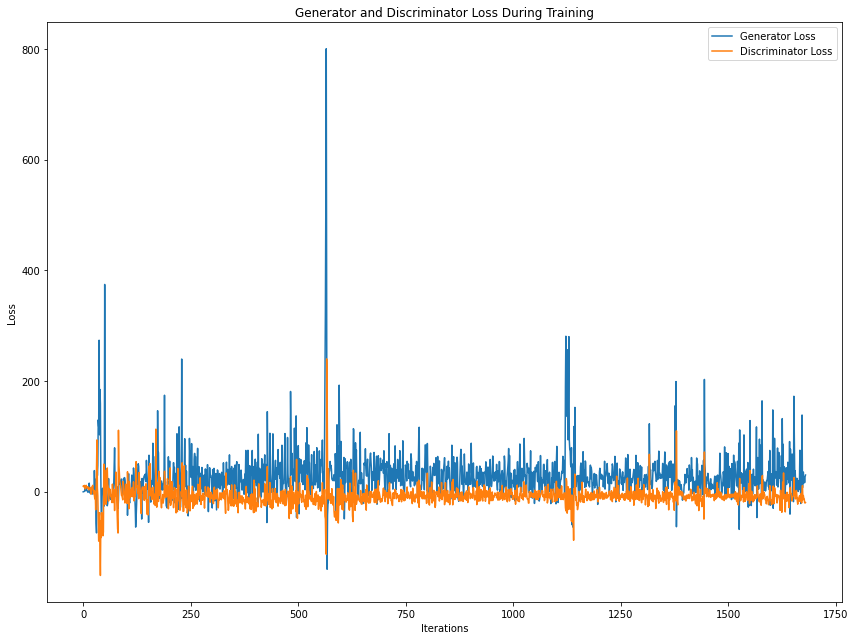

In [14]:
plot_losses_gan(gen_losses,dis_losses)

## VISUALIZE THE GENERATED DATA

#### Sample images from the generator.

Parameters:

`nb_samples:` The number of samples to generate

`num_classes:` Number of classes in dataset (optional)

`real_image_a:` Real image in subset_a (optional)

`real_image_b:` Real image in subset_b (optional)

Returns:

`img_list:` A list of generated images

In [4]:
gan = torch.load(f"/home/vuong.nguyen/vuong/augmentare/Bias Celeba/Weights_GAN/pro_gan_female_gray_200.pth")

In [9]:
img_list, img = gan.generate_samples(
    nb_samples = 36,
    num_classes = None,
    real_image_a = None,
    real_image_b = None
)

#### Plots images

Plot a number of generated images with optional label

Parameters:

`img_list:` A list of generated images (Torch tensor)

`number:` Number of images we want to plot

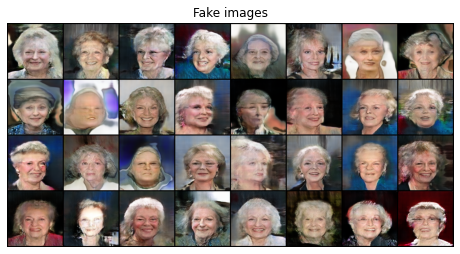

In [10]:
plot_image(img_list, number=32)